# Экзамен по ТФКП

В этом материале мы рассмотрим результаты экзамена по ТФКП студентов ФАЛТ МФТИ в январе 2020 года, изучим влияние различных факторов, которые привели к такому исходу.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

## 1. Знакомство с данными

Загрузим датасет с итогами в переменную __df__. Посмотрим размер имеющихся данных и выведем первые 5 строчек, чтобы убедиться в корректном считывании данных. 

In [2]:
df = pd.read_excel('tfkp_zh.xls')
print(df.shape)
df.head()

(56, 5)


брс  контр  сем  преп  экз
0   24     15    5     1    8
1   23     13    1     1    5
2   11      6    4     1    6
3   21     15    4     1    8
4   23     16    4     1    8

Для каждого студента известны следующие признаки:
* брс - оценка студента за работу в семестре, в неё входят баллы за посещение лекций и семинаров, сдачу заданий (max=24)
* контр - оценка студента за семестровую контрольную работу (max=16)
* сем - номер семинариста - преподавателя, который проводил у студента семинарские занятия
* преп - номер экзаменатора - преподавателя, которому студент сдавал экзамен

Итак, у нас есть вещественные признаки - брс и контр и категориальные - сем и преп.
Преподаватели закодированы следующим образом:

1. Бурмистров А.Н.
2. Ковалёв В.П.
3. Животов С.Д.
4. Сизых Г.Б.
5. Беспорточный А.И.
6. Николаев В.С.
7. Демьянов М.А.

Давайте посмотрим на графиках, как целевой признак зависит от остальных:

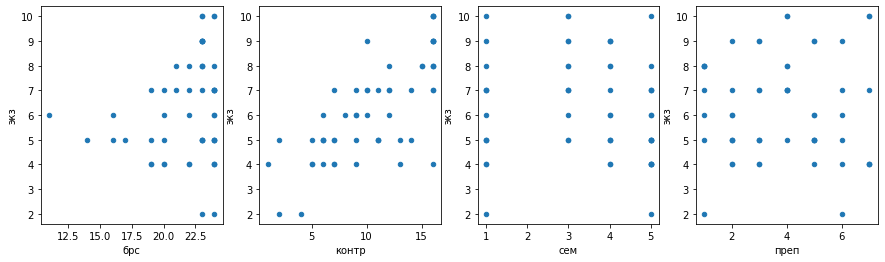

In [3]:
fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(15, 4))
for idx, feature in enumerate(df.columns[:-1]):
    df.plot(feature, "экз", subplots=True, kind="scatter", ax=axes[idx % 4])

Посмотрим на распределение оценок

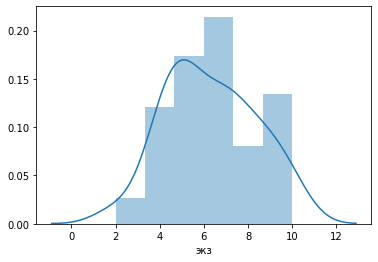

In [4]:
sns.distplot(df['экз'])

Посчитаем коэффициент корреляции Пирсона между вещественными признаками и целевой переменной

In [5]:
df[['брс','контр']].corrwith(df['экз'])

брс      0.208520
контр    0.746012
dtype: float64

Составим корреляционную матрицу между вещественными признаками

In [6]:
df[['брс','контр','экз']].corr()

брс     контр       экз
брс    1.000000  0.116839  0.208520
контр  0.116839  1.000000  0.746012
экз    0.208520  0.746012  1.000000

Видим что признаки между собой не коррелируют. Посчитаем среднее арифметическое вещественных признаков

In [7]:
df[['брс','контр']].mean()

брс      21.875000
контр    10.678571
dtype: float64

In [3]:
X_real = np.array(df[['брс','контр']])

В переменной __X_real__ записаны вещественные признаки: брс, контр в 10-балльной шкале.

### Проблема: категориальные признаки

Семинаристы и экзаменаторы - это категориальный признак. Между ними нельзя померить расстояние, поэтому просто их занумеровать и считать одним из факторов в регрессии некорректно.

Для использования модели регрессии требуется преобразовать категориальные признаки в вещественные. Рассмотрим основной способ преобразования категориальных признаков в вещественные: one-hot encoding. Его идея заключается в том, что мы преобразуем категориальный признак при помощи бинарного кода: каждой категории ставим в соответствие набор из нулей и единиц.

In [4]:
from sklearn.preprocessing import OneHotEncoder as OHE

In [5]:
encoder = OHE(sparse = False)
X_cat = encoder.fit_transform(df[['сем','преп']])

In [6]:
X = np.hstack((X_real, X_cat))

Таким образом в переменной __X_real__ хранятся значение вещественных признаков, в __X_cat__ - категориальных в бинарном виде, в __X__ - общая матрица признаков, в __y__ - значение целевой переменной

## 2. Линейная регрессия

Построим линейную регрессию на вещественных признаках. Будем считать что результат экзамена зависит от БРС и результата семестровой.

Разделим выборку на обучающую и тестовую в соотношении 80/20. На обучающей построим модель, а на тестовой проверим качество.

In [9]:
y = df['экз']

In [10]:
from sklearn.model_selection import train_test_split

(X_train, 
 X_test, 
 y_train, y_test) = train_test_split(X_real, y, 
                                     test_size=0.2, 
                                     random_state=12)

In [11]:
from sklearn.linear_model import LinearRegression

In [12]:
linear_regressor = LinearRegression()
linear_regressor.fit(X_train, y_train)
predictions = linear_regressor.predict(X_test)

Теперь оценим качество нашей модели

In [13]:
from sklearn import metrics

In [14]:
metrics.mean_absolute_error(y_test, predictions)

1.4349491005907267

In [15]:
metrics.r2_score(y_test, predictions)

0.3170487109714537

### ручная кросс-валидация

In [16]:
from sklearn.model_selection import KFold

In [18]:
regressor = LinearRegression()
kf = KFold(n_splits = 5, shuffle=True)
mae, r2 = [], []
for train, test in kf.split(X_real):
    #print("%s %s" % (train, test))
    X_train, X_test, y_train, y_test = X_real[train], X_real[test], y[train], y[test]
    regressor.fit(X_train, y_train)
    predictions = regressor.predict(X_test)
    mae.append(metrics.mean_absolute_error(y_test, predictions))
    r2.append(metrics.r2_score(y_test, predictions))
print('mae max =', np.array(mae).max(), ', min =', np.array(mae).min(), ', mean =', np.array(mae).mean())
print('r2 max =', np.array(r2).max(), ', min =', np.array(r2).min(), ', mean =', np.array(r2).mean())

mae max = 1.4967249994808398 , min = 0.9225573848676265 , mean = 1.0990427176303617
r2 max = 0.570615108441715 , min = 0.2693093562742419 , mean = 0.4518999446904049


## 3. Логистическая регрессия

Будем рассматривать задачу предсказания оценок как задачу бинарной классификации. Нам интересна вероятность того, получит ли студент хор(5) и выше (класс 1) или нет (класс 0)

In [19]:
y = np.array([1 if item >= 5 else 0 for item in df['экз'].to_list()])

In [20]:
df['y'] = y

### a) без разбиения на train и test

Вначале не будем разбивать данные на train и test: обучим модель на всей выборке и на ней же проверим качество.

In [21]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, accuracy_score, precision_score, recall_score, f1_score, roc_curve, confusion_matrix

In [22]:
regressor = LogisticRegression()
regressor.fit(X, y)
predictions = regressor.predict(X)
predictions_proba_zeros = regressor.predict_proba(X)

В переменной __predictions__ мы получили нули и единицы: каждому студенту сделали предсказание получит ли он хорошую или отличную оценку или нет. В переменной __predictions_proba_zeros__ находятся вероятности того или иного исхода. Добавим столбец с вероятностью получить хор(5) и выше в наш датафрейм.

In [23]:
df['pred'] = predictions_proba_zeros[:,1]

In [24]:
df

брс  контр  сем  преп  экз  y      pred
0    24     15    5     1    8  1  0.955488
1    23     13    1     1    5  1  0.914939
2    11      6    4     1    6  1  0.670493
3    21     15    4     1    8  1  0.965959
4    23     16    4     1    8  1  0.974511
5    23      4    5     1    2  0  0.478320
6    22     16    3     1    8  1  0.984657
7    19      9    3     1    7  1  0.894810
8    23      6    5     2    5  1  0.617594
9    24      5    5     2    4  0  0.549649
10   24      5    1     2    5  1  0.521617
11   20     16    4     2    7  1  0.973905
12   20      6    5     2    4  0  0.613323
13   23     16    4     2    9  1  0.974359
14   22      8    5     2    6  1  0.739920
15   17     11    3     2    5  1  0.936727
16   20     10    3     2    6  1  0.918853
17   24      6    5     3    5  1  0.657511
18   24     11    1     3    7  1  0.877616
19   24     10    1     3    7  1  0.843425
20   20      9    1     3    4  0  0.797987
21   23     16    4     3    9  1  0.978214
22   19      9    4     3    5  1  0.855404
23   23     16    4     3    9  1  0.978214
24   23      2    5     3    5  1  0.377955
25   22      1    5     3    4  0  0.312091
26   24     16    1     4   10  1  0.974567
27   24     12    1     4    7  1  0.924247
28   23     16    1     4    8  1  0.974417
29   24     12    5     4    7  1  0.931772
30   24     14    5     4    7  1  0.960321
31   23      7    5     4    5  1  0.764527
32   23     12    3     4    8  1  0.968609
33   23     16    3     4   10  1  0.989786
34   21     10    3     4    7  1  0.945064
35   24     11    1     5    5  1  0.863105
36   24     12    1     5    6  1  0.893541
37   19      7    1     5    4  0  0.660787
38   16     11    4     5    5  1  0.900526
39   20      7    4     5    5  1  0.747004
40   23     16    3     5    9  1  0.985222
41   23     16    3     5    9  1  0.985222
42   14     14    3     5    5  1  0.972704
43   24      9    5     5    6  1  0.799285
44   24      7    5     6    4  0  0.673254
45   23     10    1     6    9  1  0.811919
46   24      2    1     6    2  0  0.305691
47   16      9    4     6    6  1  0.824073
48   23      7    5     6    7  1  0.671929
49   24      6    5     6    5  1  0.607503
50   24     16    5     7   10  1  0.844295
51   24     13    5     7    4  0  0.696822
52   22     16    4     7    4  0  0.878218
53   19      5    4     7    4  0  0.233330
54   22     16    3     7    7  1  0.924116
55   23     16    3     7   10  1  0.924537

In [26]:
#запись dataframe в excel
df.to_excel("result.xlsx")

Теперь оценим качество нашей модели.

Выведем матрицу ошибок. Она имеет вид: $$\begin{pmatrix} TN & FP \\ FN & TP \end{pmatrix}$$
В нашем случае TN - число верно предсказанных удовлетворительных и неудовлетворительных оценок, FN - число неверно предсказанных таких оценок (на самом деле студент получил оценку выше). TP - число верно предсказанных хороших и отличных оценок, FP - число неверно предсказанных таких оценок (на самом деле студент получил оценку ниже).
                                       

In [27]:
confusion_matrix(y, predictions)

array([[ 4,  7],
       [ 1, 44]], dtype=int64)

Посчитаем еще ряд метрик, используемых в задачах бинарной классификации:

$accuracy = \frac{TP+TN}{TP+TN+FP+FN}$ - доля правильных ответов

$presicion = \frac{TP}{TP+FP}$ - насколько можно доверять классификатору в случае срабатывания

$recall = \frac{TP}{TP+FN}$ - на какой доле истинных объектов алгоритм срабатывает

$F-мера = \frac{2*presicion*recall}{presicion+recall}$

подробнее о метриках: https://habr.com/ru/company/ods/blog/328372/

In [28]:
print('accuracy', accuracy_score(y, predictions))
print('precision', precision_score(y, predictions))
print('recall', recall_score(y, predictions))
print('F-мера', f1_score(y, predictions))

accuracy 0.8571428571428571
precision 0.8627450980392157
recall 0.9777777777777777
F-мера 0.9166666666666665


Посчитаем ROC AUC и построим ROC-кривую.

ROC AUC - площадь под ROC-кривой - вероятность того, что если случайно выбрать первый и нулевой объект выборки, первый получит оценку принадлежности выше. [Подробное объяснение](https://dyakonov.org/2017/07/28/auc-roc-%D0%BF%D0%BB%D0%BE%D1%89%D0%B0%D0%B4%D1%8C-%D0%BF%D0%BE%D0%B4-%D0%BA%D1%80%D0%B8%D0%B2%D0%BE%D0%B9-%D0%BE%D1%88%D0%B8%D0%B1%D0%BE%D0%BA/)

In [29]:
roc_auc_score(y, predictions_proba_zeros[:,1])

0.892929292929293

Populating the interactive namespace from numpy and matplotlib


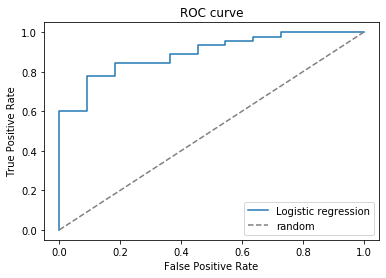

In [30]:
%pylab inline
fpr, tpr, _ = roc_curve(y, predictions_proba_zeros[:,1])
pylab.plot(fpr, tpr, label = 'Logistic regression')
pylab.plot([0, 1], [0, 1], '--', color = 'grey', label = 'random')
pylab.xlim([-0.05, 1.05])
pylab.ylim([-0.05, 1.05])
pylab.xlabel('False Positive Rate')
pylab.ylabel('True Positive Rate')
pylab.title('ROC curve')
pylab.legend(loc = "lower right")

В матрице ошибок мы увидели значительную (7 = 12,5% от выборки) долю ответов FP - ситуации, когда модель предсказывает оценку равную или выше хор(5), а на деле студент получает уд или неуд. Возможно, такой результат связан с несбалансированностью выборки - хороших и отличных оценок больше чем удовлетворительных и неудовлетворительных. 

Попробуем учесть влияние этого фактора, изменив порог отнесения к тому или иному классу. По умолчанию он равен 0.5, установим его равным 0.7: если вероятность получить хор(5) и выше равна, к примеру, 65%, то будем считать, что студент получит удовл или отправится на пересдачу.

In [31]:
predictions7 = np.array([1 if item >= 0.7 else 0 for item in predictions_proba_zeros[:,1]])

Посмотрим, как измениться матрица ошибок и метрики:

In [32]:
print('Матрица ошибок\n', confusion_matrix(y, predictions7))
print('accuracy', accuracy_score(y, predictions7))
print('precision', precision_score(y, predictions7))
print('recall', recall_score(y, predictions7))
print('F-мера', f1_score(y, predictions7))

Матрица ошибок
 [[ 9  2]
 [ 7 38]]
accuracy 0.8392857142857143
precision 0.95
recall 0.8444444444444444
F-мера 0.8941176470588236


Видим, что выросла precision и уменьшилась recall. Это значит, что доверять классификатору в случае срабатывания можно больше, но алгоритм срабатывает на меньшей доле правильных ответов. Т.е. уменьшилось число ложных срабатываний: предсказываем хор, студент получает уд-неуд - и наоборот увеличилось число ситуаций: предсказываем уд-неуд, студент получает хор.

В рассмотренной модели мы не делали разбиение выборки на обучающую и тестовую. Такой подход повышает риски переобучения и построения неадекватной модели: на наших данных классификатор будет работать хорошо, но на других - плохо. Этого можно избежать, добавив в модель кросс-валидацию.

### b) добавим cross-validation

Разбиваем выборку на n_splits = 10 фолдов таким образом, чтобы в каждом сохранилось соотношение классов. 10 раз обучим регрессор: каждый раз обучаем его на 9 фолдах, а на 10-м проверяем качество. Посмотрим на максимальное, минимальное и среднее значение метрик качества.

Подробнее о кросс-валидации: [на Хабре](https://habr.com/ru/company/ods/blog/322534/#vybor-parametrov-modeli-i-kross-validaciya), [документация scikit-learn](https://scikit-learn.org/stable/modules/cross_validation.html)

In [33]:
from sklearn.model_selection import StratifiedKFold

In [34]:
regressor = LogisticRegression()
kf = StratifiedKFold(n_splits = 10, shuffle=True, random_state=12)
acc, pre, rec, f1, roc = [], [], [], [], []
for train, test in kf.split(X,y):
    X_train, X_test, y_train, y_test = X[train], X[test], y[train], y[test]
    regressor.fit(X_train, y_train)
    predictions = regressor.predict(X_test)
    predictions_proba_zeros = regressor.predict_proba(X_test)
    acc.append(accuracy_score(y_test, predictions))
    pre.append(precision_score(y_test, predictions))
    rec.append(recall_score(y_test, predictions))
    f1.append(f1_score(y_test, predictions))
    roc.append(roc_auc_score(y_test, predictions_proba_zeros[:,1]))
print('accuracy max =', np.array(acc).max(), ', min =', np.array(acc).min(), ', mean =', np.array(acc).mean())
print('presicion max =', np.array(pre).max(), ', min =', np.array(pre).min(), ', mean =', np.array(pre).mean())
print('recall max =', np.array(rec).max(), ', min =', np.array(rec).min(), ', mean =', np.array(rec).mean())
print('f1 max =', np.array(f1).max(), ', min =', np.array(f1).min(), ', mean =', np.array(f1).mean())
print('roc auc max =', np.array(roc).max(), ', min =', np.array(roc).min(), ', mean =', np.array(roc).mean())

accuracy max = 1.0 , min = 0.4 , mean = 0.7633333333333333
presicion max = 1.0 , min = 0.6666666666666666 , mean = 0.8300000000000001
recall max = 1.0 , min = 0.5 , mean = 0.89
f1 max = 1.0 , min = 0.5714285714285715 , mean = 0.8547186147186148
roc auc max = 1.0 , min = 0.0 , mean = 0.73
